# Домашнее задание 2. Дискретно-событийное моделирование
Золотарев Антон

В рамках второго домашнего задания вам необходимо построить модифицированную модель распространения продукта по Бассу. Для реализации модели используется библиотека PySD, примеры использования которой были разобраны ранее.

Классическая модель Басса была реализована нами совместно на семинаре. Модификация модели заключена в следующем:

1. Добавить конкурирующую компанию (еще один контейнер), по аналогии с исходной (привлечение клиентов через прямую рекламу и «сарафанное радио»).
2. Клиенты после привлечения любой из компаний могут разочароваться и снова вернуться на рынок потенциальных клиентов (вероятность разочарования – новый параметр модели). Таким образом, имеется обратный поток клиентов в контейнер потенциальных клиентов.
3. Привлеченные клиенты одной компании могут напрямую воздействовать на клиентов конкурента, переманивая их в свою компанию (еще два новых параметра: уровень толерантности, т.е. восприимчивости, выраженный в форме вероятности перехода к конкуренту при контакте с его клиентами, а также уровень агрессивности привлечения, выраженный в форме вероятности прямой рекламы клиентам конкурента).

Комментарий. Очевидно, что при такой модификации все привлеченные клиенты у каждой из компаний делятся на три группы: довольные, нейтральные, недовольные.

1. Первые осуществляют «сарафанное радио» и агрессивную рекламу, но сами не восприимчивы к агрессивной рекламе со стороны конкурента, а также не возвращаются в контейнер потенциальных клиентов.
2. Вторые не осуществляют ни «сарафанное радио», ни агрессивную рекламу, сами при этом восприимчивы к агрессивной рекламе со стороны конкурента, но не возвращаются в контейнер потенциальных клиентов (то есть могут быть только переманены конкурентом и не помогают текущей компании).
3. Третьи такие же, как и вторые, но могут вернуться в контейнер потенциальных клиентов.

Пункты задания:

1. Реализовать модифицированную модель Басса. (максимум 2 балла при правильной реализации)
2. Оценить сходимость модели, т.е. устойчивость пропорции распределения клиентов. (максимум 4 балла при правильной реализации)
3. Варьированием параметров модели (
), получить обучающую и проверочную выборки для построения ML модели. Общую численность людей, а также «человеческие» параметры такие, как частота контактов, восприимчивость, агрессивность остаются постоянными, варьируем только параметры, характеризующие компании, но не людей. Построить ML модель, предсказывающую предельную пропорцию распределения клиентов по начальным параметрам. Для полученной функции доли рынка выберите произвольную точку в образе и, анализируя обратную функцию при варьировании параметров
 и
, найдите в прообразе область соответствующую этой же доли рынка с максимальным отклонением
 7%. Аналитическое построение обратной функции дает полный балл за этот пункт задания. (максимум 4 балла при правильной реализации)

Присоединить необходимо .zip архив с jupyter блокнотом реализации модели, а также с описанием оценки сходимости и варьирования параметров (можно отдельным word/latex файлом). Сходимость, варьирование и ML модель без детальных комментариев не оцениваются.

Hint. На семинаре мы разбирали три модели: Teacup, Epidemic и Predator_Prey. Первая – просто вводная для демонстрации библиотеки, а вот симбиоз двух оставшихся, по сути, и даст модифицированную модель Басса. Сами модели лежат по пути ..\PySD-Cookbook-master\source\models. После внесения изменений в .py модель ее надо подгрузить через метод pysd.load(py_model_file), например:

model = load('../PySD-Cookbook-master/source/models/teacup/teacup.py')

Бонус

Полное аналитическое решение задачи дает оценку 10. В случае частичного (например, численного) решения системы дифференциальных уравнений бонусные баллы прибавляются к основной сумме.

# Решение

Сначала подгрузим файл с аналогичной моделью, которую будем дополнять

In [ ]:
!pip install pysd

In [ ]:
%pylab inline
import pysd
model = pysd.read_vensim('/content/bass.MDL')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
model.doc

,Real Name,Py Name,Subscripts,Units,Limits,Type,Subtype,Comment
0,Customers,customers,None,person,"(nan, nan)",Stateful,Integ,None
1,FINAL TIME,final_time,None,Month,"(nan, nan)",Constant,Normal,The final time for the simulation.
2,INITIAL TIME,initial_time,None,Month,"(nan, nan)",Constant,Normal,The initial time for the simulation.
3,Potential Customers,potential_customers,None,person,"(nan, nan)",Stateful,Integ,None
4,SAVEPER,saveper,None,Month,"(nan, nan)",Auxiliary,Normal,The frequency with which output is stored.
5,TIME STEP,time_step,None,Month,"(nan, nan)",Constant,Normal,The time step for the simulation.
6,Time,time,None,None,"(nan, nan)",None,None,Current time of the model.
7,contacts of noncustomers with customers,contacts_of_noncustomers_with_customers,None,contact/Month,"(nan, nan)",Auxiliary,Normal,None
8,contacts with customers,contacts_with_customers,None,contact/Month,"(nan, nan)",Auxiliary,Normal,None
9,fruitfulness,fruitfulness,None,person/contact,"(nan, nan)",Constant,Normal,None


Подгружаем модифицированную модель, соответствующую условиям задачи. Все описания функций и их соотнесённости с поставленной задачей описаны в .py файлике

Кратко:
* initial_time = 0
* final_time = 10
* time_step = 0.01 (дельта, которая даёт 1001 итерацию для подсчёта значений переменных в системе разностных уравнений)
* saveper = 0.1 (101 подглядывание в систему, чтобы следить за сходимостью)

* $fruitfulness = {eff}^1_w={eff}^2_w=0.015$
* $market efficiency = {eff}^1_m={eff}^2_m=0.011$
* sociability = 100

<AxesSubplot:>

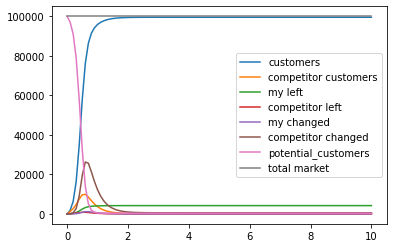

In [ ]:
model = pysd.load('/content/main.py')
result = model.run(return_columns=['customers', 'competitor customers',
                          'my left', 'competitor left',
                          'my changed', 'competitor changed',
                          'potential_customers', 'total market'])
result.plot()

In [ ]:
result = model.run()
result.iloc[-1]

FINAL TIME                                             1.000000e+01
INITIAL TIME                                           0.000000e+00
SAVEPER                                                1.000000e-01
TIME STEP                                              1.000000e-02
potential customer concentration                       3.473241e-03
new customers                                          3.666472e+03
direct market                                          3.820565e+01
contacts of noncustomers with customers                2.418844e+04
contacts with customers                                9.948896e+06
Customers                                              9.948896e+04
fruitfulness                                           1.500000e-01
market efficiency                                      1.100000e-01
Potential Customers                                    3.473241e+02
sociability                                            1.000000e+02
total market                                    

Видим, что все переменные корректно подсчитаны, total_market на всём периоде равен исходным 10000 клиентов. При этом по графикам отчётливо видна стабильная динамика всех метрик в последних изучаемых периодах -> наблюдаем сходимость.

Определим, что будем считать сошедшейся к стационарному состоянию моделью:
* если сумма 5% последних значений (то есть месяцы от 9.5 до 10) переменных "customers", "competitor customers", "potential clients" меньше 1 (такая оценка эпсилона, потому что, как-никак, нам нужны целые клиенты, в любом случае в бизнесовой задаче мы бы округляли всё после запятой до целых чисел при имеющейся постановке задачи), то модель сошлась. Иначе реализация модели с заданными параметрами некорректна для заданного final_time и такой набор параметров не следует включать в итоговую выборку для построения ML-модели.

Данная метрика обсонованно оценивает сходимость модели, поскольку вероятность случайного совпадения 6 подряд идущих значений по 3 зависимым друг от друга рядам (даже если брать в учёт автокорреляцию) предельно мала.

$P\{\left(\sum\limits_{i=5}^{10}(|X_{9.i}-X_{9.i-1}|)+\sum\limits_{i=5}^{10}(|Y_{9.i}-Y_{9.i-1}|)+\sum\limits_{i=5}^{10}(|Z_{9.i}-Z_{9.i-1}|)\right)<1\}<0.01$

где $X, Y, Z$ - функционально зависимые друг от друга случайные процессы

Короче говоря, вероятность ошибки первого рода (решили, что модель сошлась, хотя на самом деле не сошлась) здесь будет весьма мала

In [ ]:
result.index>=9.5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True])

In [ ]:
mask = result.index>=9.5
print('Сумма модулей разности последних 5% значений по количеству клиентов в 3 контейнерах')
display(result.loc[mask, 'Customers'].diff().abs()+\
  result.loc[mask, 'competitor customers'].diff().abs()+\
  result.loc[mask,'Potential Customers'].diff().abs())
print('Значение метрики')
(result.loc[mask, 'Customers'].diff().abs()+\
  result.loc[mask, 'competitor customers'].diff().abs()+\
  result.loc[mask,'Potential Customers'].diff().abs()).sum()

Сумма модулей разности последних 5% значений по количеству клиентов в 3 контейнерах


9.5              NaN
9.6     4.160654e-10
9.7     2.960405e-10
9.8     2.521574e-10
9.9     1.627427e-10
10.0    5.360334e-11
dtype: float64

Значение метрики


1.180609388029552e-09

Теперь напишем код, перебирающий по сетке возможные допустимые значения p11, p12, p21, p23

In [ ]:
def generate_parameters(p11=None, p13=None, p21=None, p23=None, eps=1.0):
    if any([p11 == None, p13 == None, p21 == None, p23 == None]):
        p11 = np.random.uniform() # генерим любое значение от 0 до 1
        p13 = np.random.uniform(0, 1 - p11) # генерием любое значение от 0 до 1-p11, чтобы учесть ограничения модели
        p21 = np.random.uniform() # генерим любое значение от 0 до 1
        p23 = np.random.uniform(0, 1 - p21) # генерием любое значение от 0 до 1-p21, чтобы учесть ограничения модели

    values = model.run(params={'p11':p11, 'p13':p13, 'p21':p21, 'p23':p23},
                       return_columns=['my share', 'competitor share'])

    if (result.loc[mask, 'Customers'].diff().abs()+\
        result.loc[mask, 'competitor customers'].diff().abs()+\
        result.loc[mask,'Potential Customers'].diff().abs()).sum() < eps:
      return {'p11': p11,
              'p13': p13,
              'p21': p21,
              'p23': p23,
              'my_share': values['my share'].iloc[-1],
              'competitor_share': values['competitor share'].iloc[-1]}
    else:
      print('Модель не сошлась при таких параметрах ', p11, p13, p21, p23)
      print('Значение метрики сходимости составило', (result.loc[mask, 'Customers'].diff().abs()+\
        result.loc[mask, 'competitor customers'].diff().abs()+\
        result.loc[mask,'Potential Customers'].diff().abs()).sum())

In [ ]:
# проверим, что не всегда модель сходится, если задать неадекватно маленький эпсилон
generate_parameters(eps=10**(-9))

Модель не сошлась при таких параметрах  0.41625490974094503 0.25112643629699816 0.00885144928367565 0.6240160665230589
Значение метрики сходимости составило 1.180609388029552e-09


In [ ]:
# проверим, что в целом функция работает
generate_parameters()

{'p11': 0.5059120902977241,
 'p13': 0.033700145315505345,
 'p21': 0.6403607005063189,
 'p23': 0.2962469348285901,
 'my share': 0.04299538778503592,
 'competitor share': 0.8459830647410475}

Запустим цикл и соберём датафрейм из приемлемых значений параметров модели, на основе которых будем обучать ML-модель.

Проведём 10.000 итераций, поскольку данного числа кажется вполне достаточно для предсказания предельной пропорции распределения клиентов по начальным параметрам

In [ ]:
from tqdm import tqdm

df = pd.DataFrame(columns=['p11', 'p13', 'p21', 'p23',
                           'my_share', 'competitor_share'])
df_list = []

with tqdm(total=5000) as pbar:
  for i in range(5000):
    tmp = generate_parameters()
    df_list.append(tmp)
    if (i>0) & (i%100==0):
      pbar.update(100)
df = df.append(df_list)
df

 98%|█████████▊| 4900/5000 [22:48<00:27,  3.58it/s]


,p11,p13,p21,p23,my_share,competitor_share
0,0.465262,0.244721,0.543379,0.019541,0.226370,0.765499
1,0.215349,0.342365,0.986162,0.009487,0.000892,0.970699
2,0.359514,0.571366,0.558305,0.205163,0.068956,0.854839
3,0.566908,0.424169,0.081669,0.101797,0.973985,0.007952
4,0.290728,0.396468,0.029768,0.165361,0.954759,0.011775
...,...,...,...,...,...,...
4995,0.632643,0.306728,0.137836,0.635165,0.976987,0.011725
4996,0.416498,0.409472,0.985275,0.013108,0.001142,0.976587
4997,0.631314,0.216763,0.892110,0.038399,0.006179,0.952013
4998,0.699161,0.217021,0.778986,0.155935,0.118598,0.858252


In [ ]:
df.my_share.describe()

count    5000.000000
mean        0.486221
std         0.451641
min         0.000014
25%         0.015066
50%         0.391510
75%         0.981806
max         0.999998
Name: my_share, dtype: float64

In [ ]:
# на всякий случай сохраним
df.to_csv('hw2_train.csv', index = False)

# ML модель

In [ ]:
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import xgboost

In [ ]:
y = df['my_share'].copy()
X = df.drop(columns=['my_share', 'competitor_share']).copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

Будем оценивать качество модели по 3 метрикам:

* RMSE - нет смысла в MAE, поскольку все значения целевой переменной в диапазоне от 0 до 1 определены относительно равномерно и выбросы должны также успешно прогнозироваться моделью при корректных входных значениях
* MAPE - люблю эту метрику, потому что даёт интерпретируемый результат о степени точности модели
* R^2 - считаем долю объяснённой дисперсии, чтобы дать какую-то оценку о качестве модели от 0 до 1

In [ ]:
def calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred):
  print("Train RMSE = %.4f" % metrics.mean_squared_error(y_train, y_train_pred, squared=False))
  print("Test RMSE = %.4f" % mean_squared_error(y_test, y_test_pred, squared=False))
  print("Test MAPE = %.4f" % metrics.mean_absolute_percentage_error(y_test, y_test_pred))
  print("Test R^2 = %.4f" % metrics.r2_score(np.array(y_test), y_test_pred))

## Моделирование

Попробуем обычный линрег

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
# make predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.2197
Test RMSE = 0.2132
Test MAPE = 21.8973
Test R^2 = 0.7767


Качество не очень (22% средней разницы между прогнозируемым и реальным значением - ну куда годится?..)

Попробуем чуть модифицированный вариант линрега с регуляризацией, авось поможет?

In [ ]:
ridge = Ridge()
ridge.fit(X_train, y_train)
# make predictions
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.2197
Test RMSE = 0.2132
Test MAPE = 21.8316
Test R^2 = 0.7768


Ничего не изменилось, воспользуемся магией бустингов

In [ ]:
bst = xgboost.XGBRegressor(n_estimators=300, max_depth=12, learning_rate=0.01)
# fit model
bst.fit(X_train, y_train)
# make predictions
y_train_pred = bst.predict(X_train)
y_test_pred = bst.predict(X_test)
calc_metrics(y_train, y_train_pred,
                y_test, y_test_pred)

Train RMSE = 0.0256
Test RMSE = 0.0636
Test MAPE = 3.9936
Test R^2 = 0.9802


Вот, так гораздо лучше, теперь ML модель хорошо выполняет поставленную задачу

## Анализ полученной функции доли рынка

Для полученной функции доли рынка выберите произвольную точку в образе и, анализируя обратную функцию при варьировании параметров p11 и p13, найдите в прообразе область соответствующую этой же доли рынка с максимальным отклонением
 7%

In [ ]:
# Выбираем произвольную точку в образе:
my_share_sample = df.iloc[0].my_share
my_share_sample

0.22636957284083298

In [ ]:
# Зафиксируем p21 & p23 для этого значения, чтобы варьировать только p11 и p13
df.iloc[0][['p21', 'p23']]

p21    0.543379
p23    0.019541
Name: 0, dtype: float64

In [ ]:
# Границы целевого значения my_share, при которых подобранное значение p11 и p13 будет учтено
lower_bound = my_share_sample*0.93
upper_bound = my_share_sample*1.07 if  my_share_sample*1.07<=1 else 1
lower_bound, upper_bound

(0.21052370274197468, 0.2422154429396913)

In [ ]:
test_row = df.iloc[0:1][['p11', 'p13', 'p21', 'p23']].copy()
test_row

,p11,p13,p21,p23
0,0.465262,0.244721,0.543379,0.019541


In [ ]:
# Пишем функцию для прогона сетки значений p11, p13
grid = []
with tqdm(total=500000) as pbar:
  for i in range(500000):
    p11 = df.iloc[0]['p11']*np.random.uniform(0, 1/df.iloc[0]['p11'])
    p13 = df.iloc[0]['p13']*np.random.uniform(0, 1/df.iloc[0]['p13'])
    test_row['p11'] = p11
    test_row['p13'] = p13
    pred = bst.predict(test_row)
    if lower_bound <= pred <= upper_bound:
      grid.append([p11, p13])
    if (i>0) & (i%1000==0):
      pbar.update(1000)
grid

 18%|█▊        | 88000/500000 [04:18<20:08, 340.96it/s]


KeyboardInterrupt: ignored

А зачем таким ужасом упарываться, если можно сразу кучу значений насэмплировать? Оставлю это тут забавы ради

In [ ]:
test_row['times'] = 10**6
sample = test_row.loc[test_row.index.repeat(test_row.times)].reset_index(drop=True)
sample['p11'] = df.iloc[0]['p11']*np.random.uniform(0, 1/df.iloc[0]['p11'], size=10**6)
sample['p13'] = np.random.uniform(0, 1-sample['p11'])
sample.drop(columns='times', inplace=True)
pred = bst.predict(sample)
pred

array([0.9713631 , 0.9024115 , 0.93378454, ..., 0.11905278, 0.05252834,
       0.6234904 ], dtype=float32)

In [ ]:
grid = sample.loc[(pred>=lower_bound) & (pred<=upper_bound)][['p11', 'p13']]
len(grid)

19206

Получается, примерно 2% из случайных выборов p11, p13 удовлетворяют условию содержания целевого значения в +-7% относительно прогнозируемого значения

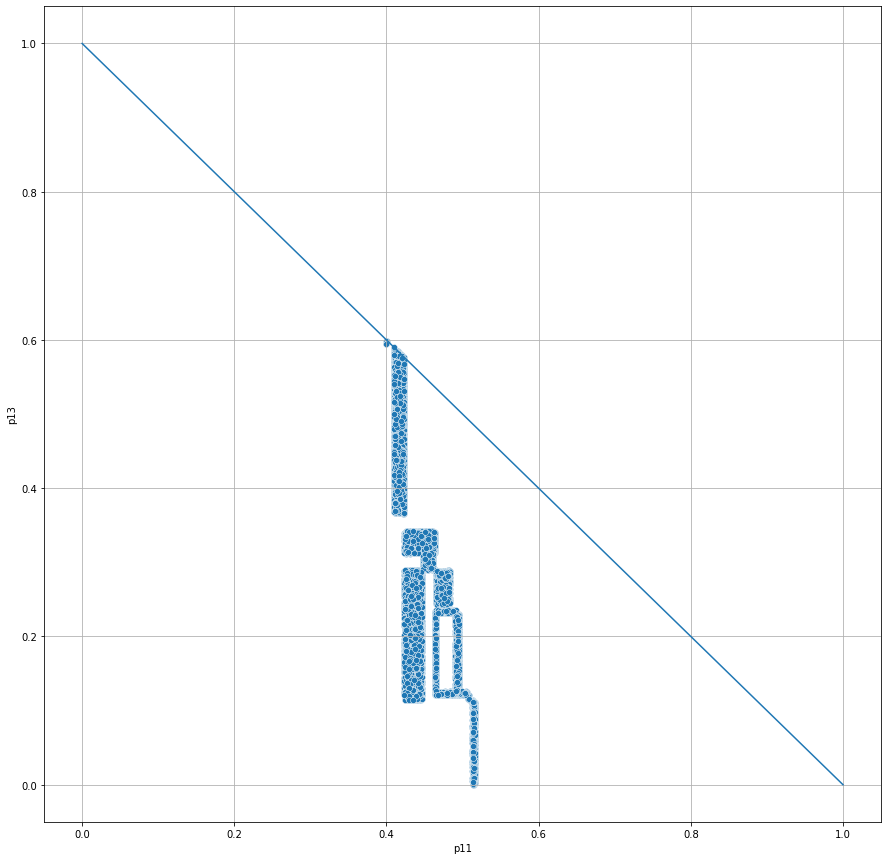

In [ ]:
plt.figure(figsize=(15, 15))
plt.grid()
sns.scatterplot(data=grid, x='p11', y='p13')
plt.plot([0, 1], [1, 0])

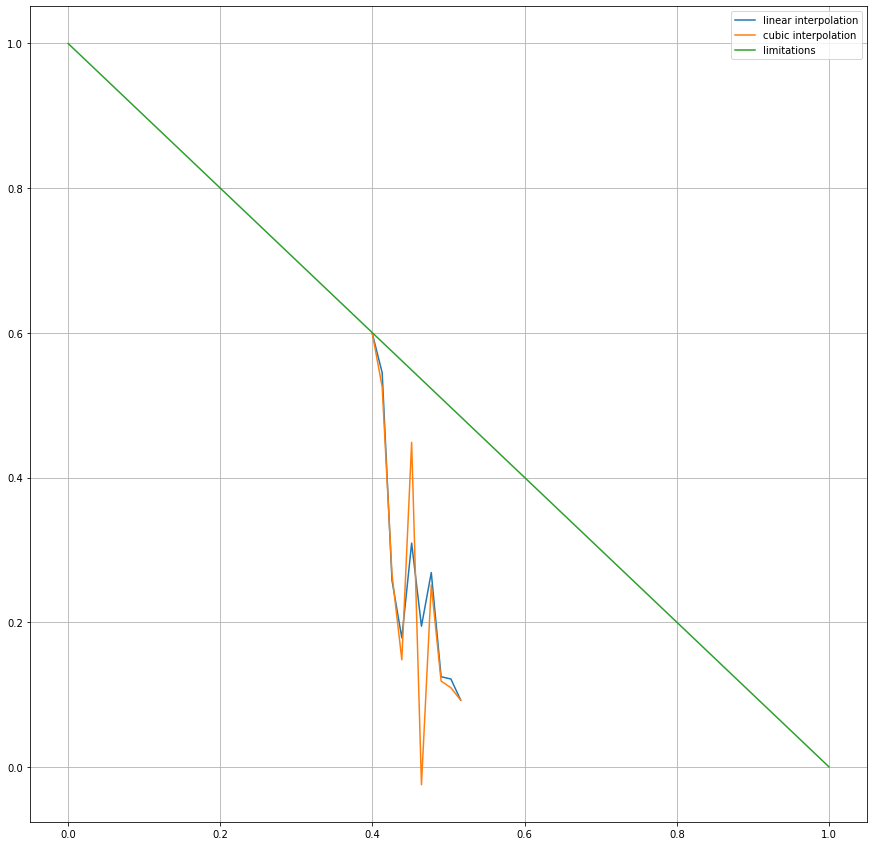

In [ ]:
from scipy.interpolate import interp1d
f1 = interp1d(grid.p11, grid.p13, kind='linear')
NUM_INTERPOLATE = 10
xnew = np.linspace(grid.p11.min(), grid.p11.max(), num=NUM_INTERPOLATE, endpoint=True)
ynew = f1(xnew)

f1 = interp1d(grid.p11, grid.p13, kind='cubic')
xnew1 = np.linspace(grid.p11.min(), grid.p11.max(), num=NUM_INTERPOLATE, endpoint=True)
ynew1 = f1(xnew)

plt.figure(figsize=(15, 15))
plt.grid()
#sns.scatterplot(data=grid, x='p11', y='p13', alpha=0.02)
plt.plot(xnew, ynew, label='linear interpolation')
plt.plot(xnew1, ynew1, label='cubic interpolation')
plt.plot([0, 1], [1, 0], label='limitations')
plt.legend()

Получилась какая-то странная траектория, го ещё по одной точке сделаем аналогичную операцию

,p11,p13,p21,p23
100,0.703073,0.198175,0.61282,0.084243


0.8813173161555065 1
329387


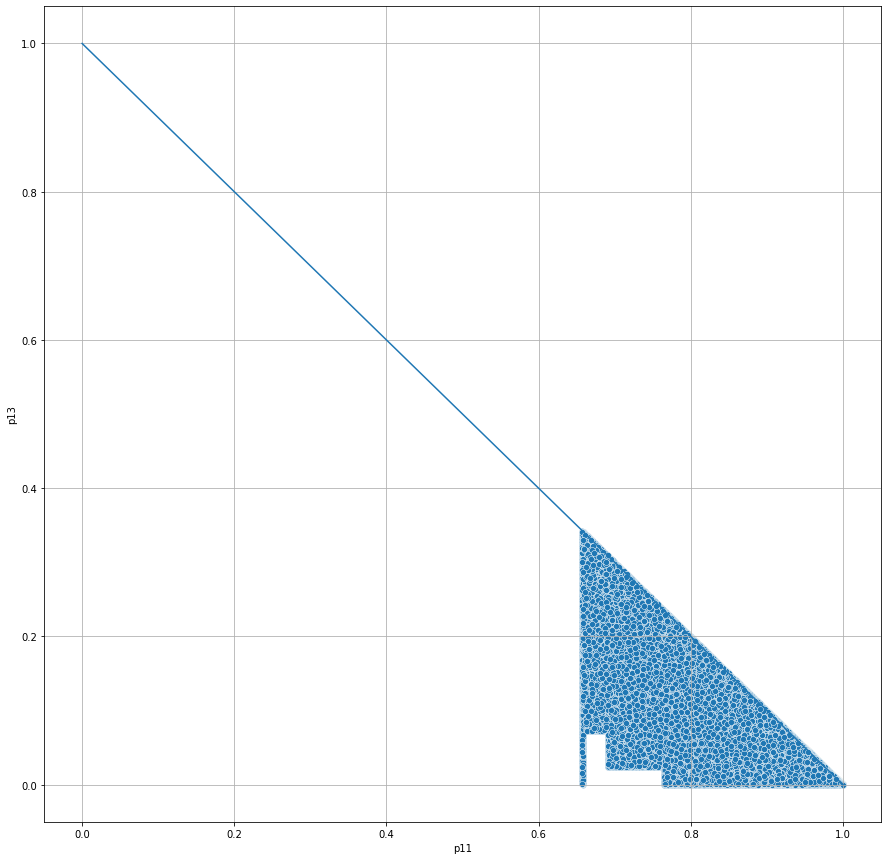

In [ ]:
test_row = df.iloc[100:101][['p11', 'p13', 'p21', 'p23']].copy()
display(test_row)
test_row['times'] = 10**6
sample = test_row.loc[test_row.index.repeat(test_row.times)].reset_index(drop=True)
sample['p11'] = df.iloc[100]['p11']*np.random.uniform(0, 1/df.iloc[100]['p11'], size=10**6)
sample['p13'] = np.random.uniform(0, 1-sample['p11'])
sample.drop(columns='times', inplace=True)

pred = bst.predict(sample)

lower_bound = df.iloc[100].my_share*0.93
upper_bound = df.iloc[100].my_share*1.07 if  df.iloc[100].my_share*1.07<=1 else 1
print(lower_bound, upper_bound)
grid = sample.loc[(pred>=lower_bound) & (pred<=upper_bound)][['p11', 'p13']]
print(len(grid))
plt.figure(figsize=(15, 15))
plt.grid()
sns.scatterplot(data=grid, x='p11', y='p13')
plt.plot([0, 1], [1, 0])

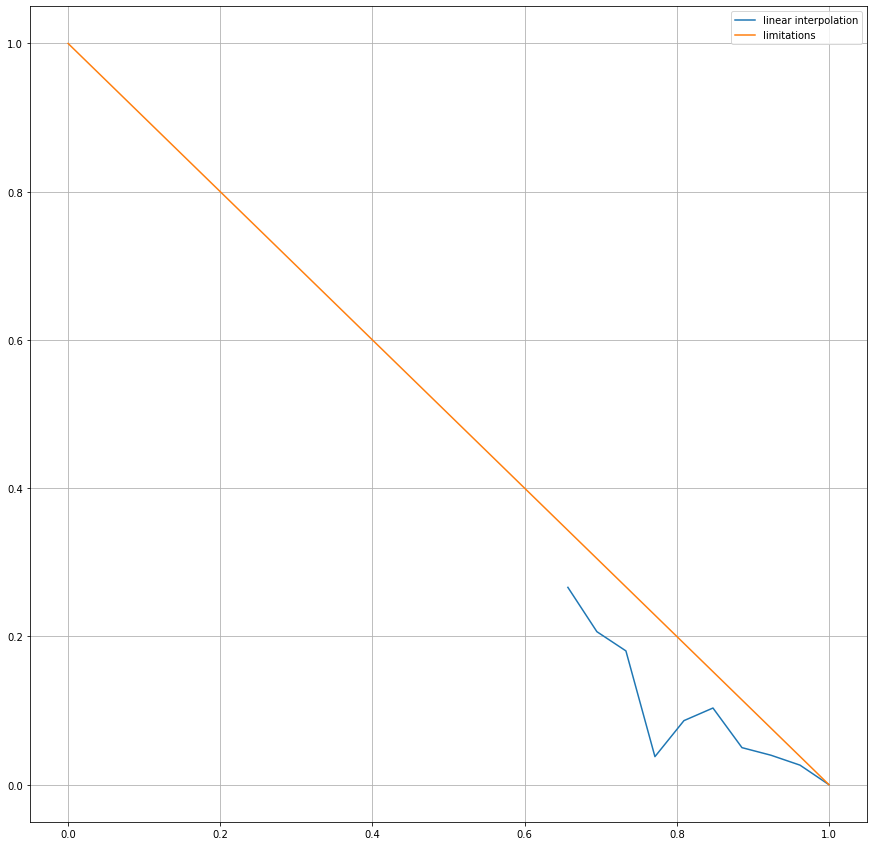

In [ ]:
from scipy.interpolate import interp1d
f1 = interp1d(grid.p11, grid.p13, kind='linear')
NUM_INTERPOLATE = 10
xnew = np.linspace(grid.p11.min(), grid.p11.max(), num=NUM_INTERPOLATE, endpoint=True)
ynew = f1(xnew)


plt.figure(figsize=(15, 15))
plt.grid()
#sns.scatterplot(data=grid, x='p11', y='p13', alpha=0.02)
plt.plot(xnew, ynew, label='linear interpolation')
plt.plot([0, 1], [1, 0], label='limitations')
plt.legend()

Вроде бы что-то красивенькое. Видим, что для почти полного захвата рынка (88%+ клиентов) нам нужно околомаксимальное значение p11 и околоминимальное для p13

Всё логично, модель работает, траектория построена, ура!